In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from tqdm.notebook import tqdm
import ast
import operator
import umap
from collections import defaultdict
import requests
import spacy
import re
import json

from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification

nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package wordnet to /Users/ip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/ip/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
df_complete = pd.read_csv('full_dataset.csv')
df_complete.drop(['Unnamed: 0', 'link'], axis=1, inplace=True)
df_complete.reset_index(drop=True, inplace=True)
df_complete.head()

,title,ingredients,directions,source,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


## Data preparation 
The full data set contains approximatelly 2 million recipes. A part of them from the Recipe1M dataset and other gathered recipes from different sources. I will be focusing on the recipes from Recipe1M dataset. 

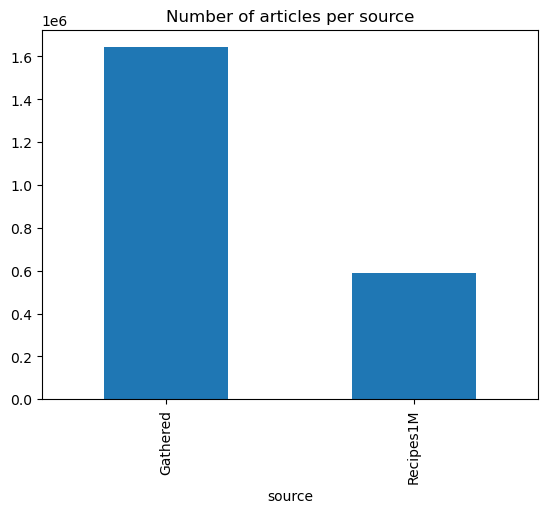

In [100]:
df_complete.source.value_counts().plot(kind='bar')
plt.title('Number of articles per source')
#plt.savefig('articles_per_source.png')
plt.show()


In [21]:
df = df_complete[df_complete['source'] == 'Recipes1M']
#df.to_csv('data_1M.csv', index=False)
#df  = pd.read_csv('data_1M.csv')
df.head()

,title,ingredients,directions,source,NER
1643098,Worlds Best Mac and Cheese,"[""6 ounces penne"", ""2 cups Beechers Flagship C...","[""Preheat the oven to 350 F. Butter or oil an ...",Recipes1M,"[""penne"", ""Beechers Flagship Cheese Sauce"", ""C..."
1643099,Dilly Macaroni Salad Recipe,"[""1 c. elbow macaroni"", ""1 c. cubed American c...","[""Cook macaroni according to package direction...",Recipes1M,"[""elbow macaroni"", ""American cheese"", ""celery""..."
1643100,Gazpacho,"[""8 tomatoes, quartered"", ""Kosher salt"", ""1 re...","[""Add the tomatoes to a food processor with a ...",Recipes1M,"[""tomatoes"", ""Kosher salt"", ""red onion"", ""gree..."
1643101,Kombu Tea Grilled Chicken Thigh,"[""2 Chicken thighs"", ""2 tsp Kombu tea"", ""1 Whi...","[""Pierce the skin of the chicken with a fork o...",Recipes1M,"[""Chicken"", ""White pepper""]"
1643102,Zucchini Nut Bread,"[""2 cups flour"", ""1 tablespoon cinnamon"", ""2 t...","[""Sift dry ingredients."", ""beat eggs untill fr...",Recipes1M,"[""flour"", ""cinnamon"", ""baking soda"", ""salt"", ""..."


In [22]:
df.reset_index(drop=True, inplace=True)
df.drop('source', axis=1, inplace=True)
df.head()

/var/folders/1y/r5jmwn4n0r599hsjjrhbwstm0000gn/T/ipykernel_13312/2629691920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('source', axis=1, inplace=True)


,title,ingredients,directions,NER
0,Worlds Best Mac and Cheese,"[""6 ounces penne"", ""2 cups Beechers Flagship C...","[""Preheat the oven to 350 F. Butter or oil an ...","[""penne"", ""Beechers Flagship Cheese Sauce"", ""C..."
1,Dilly Macaroni Salad Recipe,"[""1 c. elbow macaroni"", ""1 c. cubed American c...","[""Cook macaroni according to package direction...","[""elbow macaroni"", ""American cheese"", ""celery""..."
2,Gazpacho,"[""8 tomatoes, quartered"", ""Kosher salt"", ""1 re...","[""Add the tomatoes to a food processor with a ...","[""tomatoes"", ""Kosher salt"", ""red onion"", ""gree..."
3,Kombu Tea Grilled Chicken Thigh,"[""2 Chicken thighs"", ""2 tsp Kombu tea"", ""1 Whi...","[""Pierce the skin of the chicken with a fork o...","[""Chicken"", ""White pepper""]"
4,Zucchini Nut Bread,"[""2 cups flour"", ""1 tablespoon cinnamon"", ""2 t...","[""Sift dry ingredients."", ""beat eggs untill fr...","[""flour"", ""cinnamon"", ""baking soda"", ""salt"", ""..."


In [23]:
df['ingredients_list'] = df['NER'].apply(lambda x: ast.literal_eval(x))



ingredients_count = defaultdict(int)
for i in range(df.shape[0]):
    ingredients = df.iloc[i]['ingredients_list']
    for ingredient in ingredients:
        if ingredient.lower() not in ingredients_count:
            ingredients_count[ingredient.lower()] += 1
        else:
            ingredients_count[ingredient.lower()] += 1

/var/folders/1y/r5jmwn4n0r599hsjjrhbwstm0000gn/T/ipykernel_13312/1275412081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients_list'] = df['NER'].apply(lambda x: ast.literal_eval(x))


In [24]:
ingredients_count

defaultdict(int,
            {'penne': 663,
             'beechers flagship cheese sauce': 2,
             'cheddar': 1705,
             'gruyere cheese': 1468,
             'chipotle chili powder': 26,
             'butter': 136492,
             'flour': 108888,
             'milk': 81914,
             'semihard cheese': 27,
             'semisoft cheese': 13,
             'kosher salt': 35897,
             'garlic': 146540,
             'elbow macaroni': 1378,
             'american cheese': 1368,
             'celery': 26243,
             'green pepper': 9677,
             'pimento': 469,
             'mayonnaise': 22406,
             'vinegar': 10083,
             'salt': 275713,
             'dill': 5675,
             'tomatoes': 57908,
             'red onion': 17467,
             'green bell pepper': 6266,
             'red bell pepper': 10173,
             'yellow bell pepper': 1744,
             'cucumber': 7410,
             'extra-virgin olive oil': 20060,
             'fres

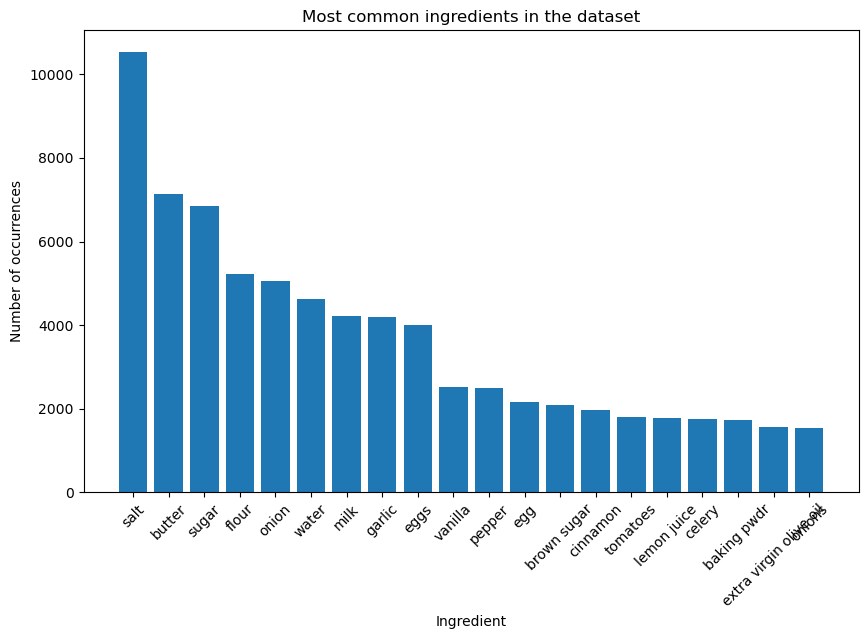

In [99]:
sorted_ingredients = sorted(ingredients_count.items(), key=operator.itemgetter(1), reverse=True)

plt.figure(figsize=(10,6))
plt.bar([i[0] for i in sorted_ingredients[:20]], [i[1] for i in sorted_ingredients[:20]])
plt.xticks(rotation=45)
plt.title('Most common ingredients in the dataset')
plt.ylabel('Number of occurrences')
plt.xlabel('Ingredient')
#plt.savefig('most_common_ingredients.png')
plt.show()



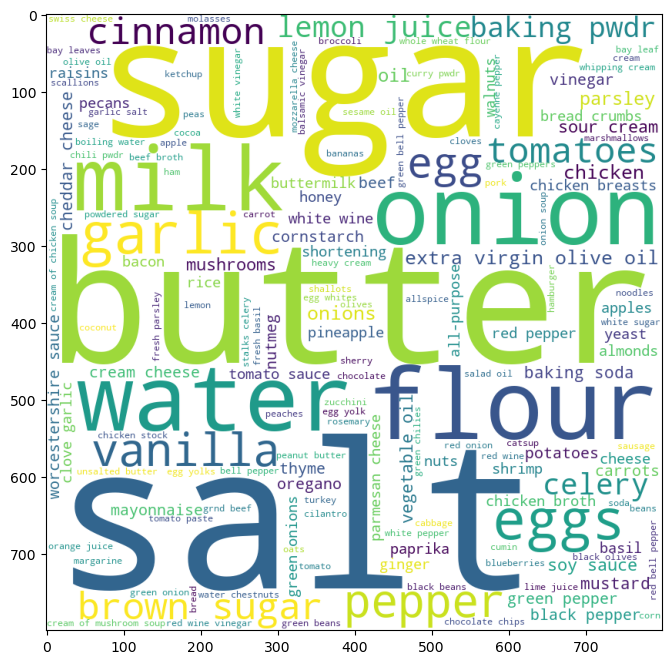

In [98]:
#generate a wordcloud of the most common ingredients
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate_from_frequencies(ingredients_count)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
#plt.savefig('wordcloud_ingredients.png')

I investigate if there is some patters that can be observed into the structure of the recipes distribution by performing clustering analysis using the recipes embedings obtained using RecipeBERT, a fine tunned model on recipe data. (Note: I obtained the text embedings using colab with a GPU runtime session for faster processing of the sample data of 250K observations, then I save the embeddings and load them locally)

In [27]:
#sample = df.sample(250000, random_state=91).reset_index(drop=True)
#sample.to_csv('sampled_1M.csv')
sample = pd.read_csv('sampled_1M.csv')
sample.drop('Unnamed: 0', axis=1, inplace=True)
sample.reset_index(drop=True, inplace=True)
sample.head()

,title,ingredients,directions,NER,ingredients_list
0,German Sweet Potato Salad,"[""2 medium sweet potatoes"", ""1 1/2 cups caulif...","[""Prick the sweet potatoes with a fork, and mi...","[""sweet potatoes"", ""cauliflower florets"", ""whi...","['sweet potatoes', 'cauliflower florets', 'whi..."
1,Black Bean Chili,"[""2 cup black beans, soak over nite"", ""4 cup w...","[""recipe was based on recipe from cookbook 'In...","[""black beans"", ""water"", ""bell pepper"", ""onion...","['black beans', 'water', 'bell pepper', 'onion..."
2,Madeira Duck With Mixed Wild Mushrooms,"[""4 boneless duck breasts, skinned"", ""3 garlic...","[""Slice the duck breasts and place in a shallo...","[""duck breasts"", ""garlic"", ""chicken"", ""madeira...","['duck breasts', 'garlic', 'chicken', 'madeira..."
3,Grand Salmon Spread,"[""1 pkg. (3 oz.) PHILADELPHIA Cream Cheese, so...","[""Mix cream cheese, juice and horseradish unti...","[""PHILADELPHIA Cream Cheese"", ""lemon juice"", ""...","['PHILADELPHIA Cream Cheese', 'lemon juice', '..."
4,Bean And Pasta Salad Recipe,"[""4 ounce rotini (corkscrew) pasta"", ""15 ounce...","[""1."", ""Cook pasta till al dente in plenty of ...","[""rotini"", ""black beans"", ""red pepper"", ""red o...","['rotini', 'black beans', 'red pepper', 'red o..."


In [28]:

sample['ingredients'] = sample['ingredients'].apply(lambda x: 'ingredients: ' + x)
sample['directions'] = sample['directions'].apply(lambda x: 'directions: ' + x)
sample['text'] =  sample['ingredients'] + ' ' + sample['directions']

#sample.to_csv('sampled_whole_text.csv', index=False)


In [29]:
#from sentence_transformers import SentenceTransformer
#model = SentenceTransformer("alexdseo/RecipeBERT")

#texts = list(sample['text'])
#embeded_texts = model.encode(texts)

embeded_text = np.load('embeded_texts2.npy')

In [30]:
reducer = umap.UMAP(random_state = 91)
embeded_directions_2D = reducer.fit_transform(embeded_text)

/Users/ip/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


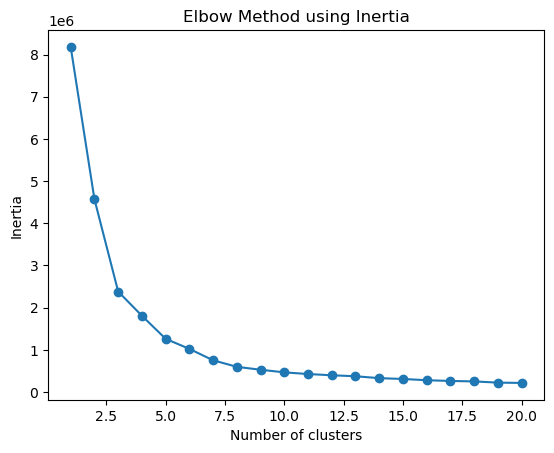

In [97]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans_inertia = []
for k in range(1,21):
  kmeans  = KMeans(n_clusters = k)
  kmeans.fit(embeded_directions_2D)
  kmeans_inertia.append(kmeans.inertia_)

#plot our results
plt.plot(range(1, 21), kmeans_inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method using Inertia')
#plt.savefig('clustering_elbow_method.png')
plt.show()


In [36]:
optimal_k = 3

kmeans  = KMeans(n_clusters = optimal_k)
kmeans.fit(embeded_directions_2D)
labels = kmeans.predict(embeded_directions_2D)

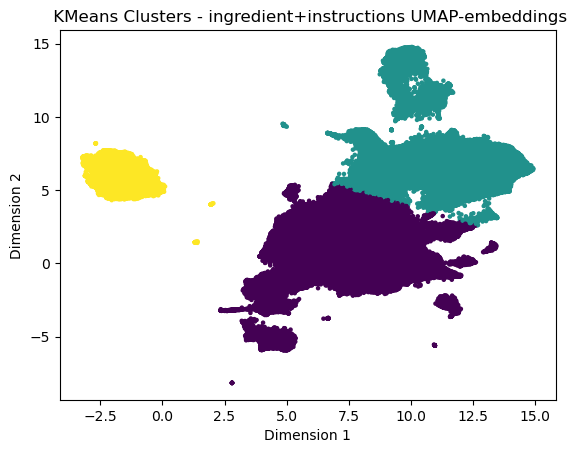

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(91)
plt.scatter(embeded_directions_2D[:,0], embeded_directions_2D[:,1], c = labels, s=5)
plt.title(' KMeans Clusters - ingredient+instructions UMAP-embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#plt.savefig('kmeans_clusters.png')
plt.show()


In [39]:
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances

closest, _ = pairwise_distances_argmin_min(X = kmeans.cluster_centers_, Y = embeded_directions_2D, metric='euclidean')

for i, center in enumerate(closest[:3]):
  distance_center = pairwise_distances(X = [embeded_directions_2D[center]], Y = embeded_directions_2D, metric = 'euclidean')[0]
  top_ten = np.argsort(distance_center)[1:11]
  print(sample.iloc[center]['title'], '\n')
  print(f"***************TOP TEN TO CENTER {i+1}****************************** \n" )
  for i, index in enumerate(top_ten):
    print(i+1, ':', sample.iloc[index]['title'], "\n")

Delicious, Easy, Restaurant-Quality Eggplant 

***************TOP TEN TO CENTER 1****************************** 

1 : Eggplant Parmesan 

2 : Easy Homemade Donut Holes 

3 : Chipotle Turkey Chili Recipe 

4 : Creamy Hot Acorn Squash Soup 

5 : Spicy Fish Taco Bowls 

6 : Grilled Chicken - Southeast Asia Style 

7 : Spaghetti Squash with Fresh Veggies and Homemade Pesto! 

8 : Eggplant Baked With Cheeses 

9 : Cheeseburger Pie 

10 : Steal This BBQ Recipe 

Ww Strawberry Pie 

***************TOP TEN TO CENTER 2****************************** 

1 : Peanut Butter Cream Pie 

2 : Carmel Apple Cheesecake 

3 : Auntie Lin's Killer Strawberry Shortcake 

4 : No Bake Cheesecake Balls 

5 : Summertime Chocolate Berry Pie 

6 : Lemon Cream Cheese Pie 

7 : Mini Mignon's Oreo Ice Cream Pie 

8 : Lori's Easy Magic Shell Ice Cream Dessert 

9 : Easy Ice Cream Cake 

10 : Lemon Cheesecake Squares 

Asiago Cheese Puffs Recipe 

***************TOP TEN TO CENTER 3****************************** 

1 : Bee

Investigate the ingredients distribution within individual clusters. In this way we have a feeling about the nature of the ingredients and recipes in each cluster. 

In [54]:
(labels == 0).astype(int).sum(), (labels == 1).astype(int).sum(), (labels == 2).astype(int).sum()

(145777, 80092, 24131)

In [43]:
#create a dictioary of ingredients and their frequencies for every cluster
sample['ingredients_list'] = sample['NER'].apply(lambda x: ast.literal_eval(x))

ingredients_clusters = []
for i in range(optimal_k):
  ingredients_count = defaultdict(int)
  cluster = sample[labels == i]
  for j in range(cluster.shape[0]):
    ingredients = cluster.iloc[j]['ingredients_list']
    for ingredient in ingredients:
      if ingredient.lower() not in ingredients_count:
        ingredients_count[ingredient.lower()] += 1
      else:
        ingredients_count[ingredient.lower()] += 1
  ingredients_clusters.append(ingredients_count)


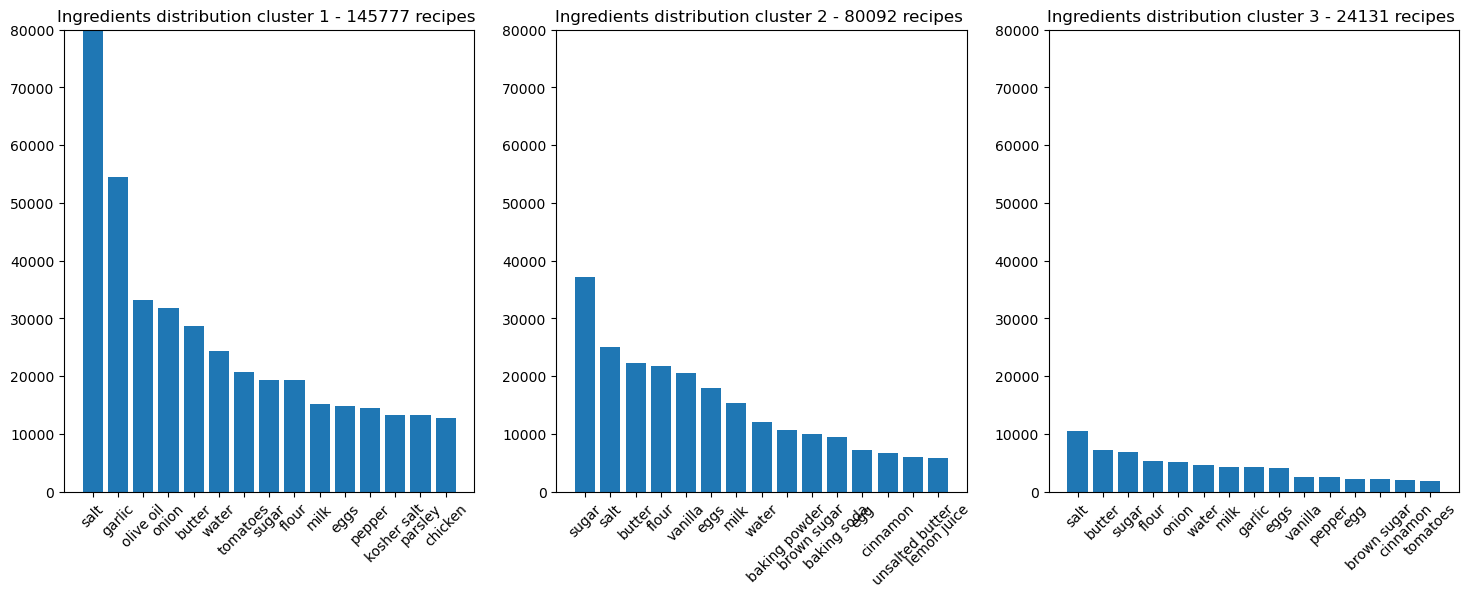

In [95]:
#build 3 bar plots of the most common ingredients in each cluster
plt.figure(figsize=(18, 6))
for i in range(optimal_k):
  sorted_ingredients = sorted(ingredients_clusters[i].items(), key=operator.itemgetter(1), reverse=True)
  plt.subplot(1, 3, i+1)
  plt.bar([i[0] for i in sorted_ingredients[:15]], [i[1] for i in sorted_ingredients[:15]])
  plt.title(f'Ingredients distribution cluster {i+1} - {(labels == i).astype(int).sum()} recipes ')
  plt.ylim(0, 80000)
  plt.xticks(rotation=45)
#plt.savefig('ingredients_distribution_clusters.png')

plt.show()


It seams that there is a very distinct cluster of pastry recipes, but the other two clusters have a similar distribution of ingredients. 

In [11]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model="google/flan-t5-large")



Device set to use mps:0


In [16]:
result = pipe("return the quantity and the unit from the following recipe instruction: 'use 2 cans of tomato juice")
print(result)

[{'generated_text': '2 cans of tomato juice'}]


## Build nutrition information dataset 
For every ingredient in the ingredient dictionary that I build I get the nutrition information using the API of USDA FoodCentral Data. 

In [61]:
def get_nutrition(ingredient):
    '''
    This function gets the nutrition information of an ingredient from the USDA database
    Input:
         ingredient (str): the name of the ingredient
    Output: 
        data (dict): the nutrition information of the ingredient
    '''
    api_key = "lU7DvgFUcb8QaLIZsNYJGpBcUvJGVM5I8LDvjTOc"  
    base_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    
    query = ingredient
    params = {
        "query": query,
        "pageSize": 1, 
        "api_key": api_key
}
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error: {response.status_code}")


#Exemple of how to get the nutrition information of sweet potatoes
sp_nutrients = get_nutrition('sweet potatoes')

food = sp_nutrients['foods'][0]
serving_size = food['servingSize']
description = food['foodNutrients']
nutrients = food['foodNutrients']

print(f"Serving size: {serving_size}")
for nutrient in nutrients:
    print(f"{nutrient['nutrientName']}: {nutrient['value']} {nutrient['unitName']}")

Serving size: 85.0
Protein: 1.18 G
Total lipid (fat): 0.0 G
Carbohydrate, by difference: 20.0 G
Energy: 82.0 KCAL
Total Sugars: 4.71 G
Fiber, total dietary: 3.5 G
Calcium, Ca: 35.0 MG
Iron, Fe: 0.59 MG
Potassium, K: 341 MG
Sodium, Na: 53.0 MG
Vitamin D (D2 + D3), International Units: 0.0 IU
Cholesterol: 0.0 MG
Fatty acids, total trans: 0.0 G
Fatty acids, total saturated: 0.0 G


In [62]:
sample['ingredients_list'] = sample['NER'].apply(lambda x: ast.literal_eval(x))

ingredients_dict = defaultdict(int)
for i in range(sample.shape[0]):
    ingredients = sample.iloc[i]['ingredients_list']
    for ingredient in ingredients:
        if ingredient.lower() not in ingredients_dict:
            ingredients_dict[ingredient.lower()] += 1
        else:
            ingredients_dict[ingredient.lower()] += 1

print(len(ingredients_dict.keys()))

55259


When I focus on the ingredients encountered in the sampled dataframe (250K recipes), there are 55259 unique ingredients. So, I decide to focus on a restricted set of ingredients, given that some ingredients only appear in a very small number of recipes or some ingredients that apear in the dictionary are mistakenly identified as being ingredients in the first place. Thus, I decide to only consider ingredients which are present in at least 10 recipes and are not found in the english stop_words dictionary. 

In [63]:
ingredients_dict = {k:v for k,v in ingredients_dict.items() if v >= 10}
ingredients_dict = {k:{'count':v} for k,v in ingredients_dict.items()}
ingredients_dict = {key: value for key, value in ingredients_dict.items() if key.lower() not in stop_words and key.lower()!='+'}
print(len(ingredients_dict.keys()))
ingredients_dict

6075


{'sweet potatoes': {'count': 1436},
 'cauliflower florets': {'count': 101},
 'white wine vinegar': {'count': 1772},
 'packet': {'count': 376},
 'scallions': {'count': 5211},
 'bacon bits': {'count': 324},
 'parsley': {'count': 15560},
 'salt': {'count': 117284},
 'black beans': {'count': 2929},
 'water': {'count': 40869},
 'bell pepper': {'count': 1356},
 'onion': {'count': 38968},
 'celery': {'count': 11070},
 'tomatoes': {'count': 24387},
 'carrot': {'count': 6158},
 'garlic': {'count': 62068},
 'chilies': {'count': 312},
 'beer': {'count': 697},
 'cayenne pepper': {'count': 6287},
 'chili powder': {'count': 5705},
 'sour cream': {'count': 11017},
 'duck breasts': {'count': 79},
 'chicken': {'count': 15133},
 'madeira wine': {'count': 85},
 'mixed mushrooms': {'count': 106},
 'fresh parsley': {'count': 2484},
 'cornflour': {'count': 348},
 'philadelphia cream cheese': {'count': 1469},
 'lemon juice': {'count': 19216},
 'horseradish': {'count': 1379},
 'salmon': {'count': 2135},
 'shr

We can see that the number of ingredients reduces drastically, only 6075 remaining unique ingredients in the dictionary. 

The next limitation that I consider in this part of the project is the API request limit of 1000 requests per hour. I split the dictionary into 6 equal smaller dictionaries in order to be able to process it one at a time.  

In [64]:
def split_dict(input_dict, num_parts):
    '''Split a dictionary into multiple parts to comply with the 1000 items limit of the API
    
    Input: 
        dictionary to split, number of parts(int)
    Output: 
        list(dictionaries)
    '''
    items = list(input_dict.items())
    
    chunk_size = len(items) // num_parts

    split_dicts = [
        dict(items[i:i + chunk_size]) for i in range(0, len(items), chunk_size)
    ]
    
    return split_dicts

list_of_dicts = split_dict(ingredients_dict, 6)

In [ ]:
### This cell will take a long time to run. 
### It will query the USDA FoodData Central API for each ingredient in the ingredients_dict
### 1000 requests per hour are allowed for the free API key

### ONLY UNCOMMENT IF YOU WANT TO RUN THIS CELL  
'''
dict4 = list_of_dicts[3]

for ingredient in dict4.keys():
    response = get_nutrition(ingredient)
    if response and 'foods' in response and response['foods']:
        food = response["foods"][0]
    else: 
        continue
    if 'servingSize' in food.keys():
        serving_size = food['servingSize']
    else: 
        serving_size = 100
    if 'foodNutrients' in food.keys():   
        nutrients = food["foodNutrients"]
    else:
        continue
    for nutrient in nutrients: 
        if 'nutrientName' not in nutrient.keys() or 'value' not in nutrient.keys():
            continue
        dict4[ingredient][nutrient['nutrientName']] = nutrient['value']*100/serving_size
        '''

#ingredients_df4 = pd.DataFrame.from_dict(dict4, orient='index')
#ingredients_df4 = ingredients_df4[['count', 'Protein', 'Total lipid (fat)', 'Carbohydrate, by difference', 'Total Sugars','Fiber, total dietary' , 'Energy']]
#ingredients_df4.to_csv('ingredients_nutrients4.csv')

In [65]:
## IN THIS CELL I PUT ALL THE DATAFRAMES INTO ONE

#ingredients_df1 = pd.read_csv('ingredients_nutrients1.csv')
#ingredients_df2 = pd.read_csv('ingredients_nutrients2.csv')
#ingredients_df3 = pd.read_csv('ingredients_nutrients3.csv')
#ingredients_df4 = pd.read_csv('ingredients_nutrients4.csv')
#ingredients_df5 = pd.read_csv('ingredients_nutrients5.csv')
#ingredients_df6 = pd.read_csv('ingredients_nutrients6.csv')

#ingredients_df = pd.concat([ingredients_df1, ingredients_df2, ingredients_df3, ingredients_df4, ingredients_df5, ingredients_df6])
#ingredients_df.to_csv('ingredients_nutrients.csv')

ingredients_df = pd.read_csv('ingredients_nutrients.csv')
ingredients_df.drop('Unnamed: 0.1', axis=1, inplace=True)
ingredients_df.rename(columns={'Unnamed: 0':'ingredient'}, inplace=True)
ingredients_df.rename(columns={'Total lipid (fat)': 'Fat', 
                            'Carbohydrate, by difference': 'Carbs',
                            'Total Sugars': 'Sugar', 
                            'Fiber, total dietary': 'Fibers', 
                            'Energy': 'Kcal'}, inplace=True)
ingredients_df.head()


,ingredient,count,Protein,Fat,Carbs,Sugar,Fibers,Kcal
0,sweet potatoes,1436,1.388235,0.00,23.529412,5.541176,4.117647,96.470588
1,cauliflower florets,101,2.764706,0.00,5.541176,2.764706,2.823529,34.117647
2,white wine vinegar,1772,0.000000,0.00,0.000000,NaN,NaN,886.666667
3,packet,376,2.170000,0.00,89.100000,80.700000,0.000000,365.000000
4,scallions,5211,1.830000,0.19,7.340000,2.330000,2.600000,32.000000


Although the nutritional information retrieved from USDA FoodCentral data is much richer, for this project I choose to restrict it to macro nutrients information (Protein, Fat, Carbohydrates + Sugar and Fiber intakes) and caloric info. The table depicts nutritional information per 100 grams of ingredient. Nevertheless, these are estimates build on the assumption that the all the ingredient portion sizes described on the USDA FoodCentral data are expressed in grams, but it is likely that some of them are not. 

I clean the obtained ingredient nutrition data by removing illogical entries and mission observations 

In [66]:
#eliminate ingredients that seam to be illogical 
ingredients_df = ingredients_df[(ingredients_df['Carbs'] < 100) 
                         & (ingredients_df['Kcal'] < 1000)
                         & (ingredients_df['Kcal'] > 0)
                         & (ingredients_df['Fat'] < 100)
                         & (ingredients_df['Protein'] < 100)
                         & (ingredients_df['Sugar'] < 100)]
ingredients_df = ingredients_df.dropna()
ingredients_df.to_csv('ingredients_nutrients_cleaned.csv')
ingredients_df.shape

(3429, 8)

In [67]:
ingredients_df.head()

,ingredient,count,Protein,Fat,Carbs,Sugar,Fibers,Kcal
0,sweet potatoes,1436,1.388235,0.00,23.529412,5.541176,4.117647,96.470588
1,cauliflower florets,101,2.764706,0.00,5.541176,2.764706,2.823529,34.117647
3,packet,376,2.170000,0.00,89.100000,80.700000,0.000000,365.000000
4,scallions,5211,1.830000,0.19,7.340000,2.330000,2.600000,32.000000
5,bacon bits,324,32.000000,25.90,28.600000,0.000000,10.200000,476.000000


## Extract ingredient quantities for each recipe 

Here I tested two approaches: 
1. Use text to text model __T5-large__ wich I prompt to identify quantity in a given text. 
2. Apply smaller model __en_core_web_sm__ to indentify alpha numeric elements in text which I assume are coresponding to the ingredient quantities. 

In [68]:
nlp = spacy.load("en_core_web_sm")  

#define 
#  - units that are used in recipes
#  - alpha numerical set to exclude numbers that are written as words
#  - conversion dictionary to convert units to grams


units = ['mililiter', 'ml', 'liter', 'l', 'gram', 
         'g', 'kilogram', 'kg', 'teaspoon', 'tsp', 'tablespoon', 'tbsp', 
         'cup', 'c', 'pint', 'pt', 'quart', 'qt', 'gallon', 'gal', 'ounce', 
         'oz', 'pound', 'lb', 'cups', 'teaspoons', 'tablespoons', 'pints', 'pounds',
         'quarts', 'gallons', 'ounces', 'liters', 'grams', 'kilograms', 'milliliters', 'kilograms',
          'can', 'cans', 'package','bunch','head', 'spring', 'pinch', 'dash' ]
alpha_numerical_set = {'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
                       'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen',
                       'nineteen', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety',
                       'hundred', 'thousand', 'dozen', 'half', 'quarter', 'third', 'fourth', 'fifth', 
                       'sixth', 'seventh', 'eighth', 'ninth', 'tenth', 'hundreds', 'thousands', 'dozens', 
                       'halves', 'quarters', 'thirds', 'fourths', 'fifths', 'first', 'second', 'third', 'fourth', 
                       'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth'}
conversion_dict_to_grams = {
    "ml": 1,   
    'mililiters': 1, 
    "l": 1000, 
    "liter": 1000, 
    "liters": 1000,
    "g": 1,
    'grams':1, 
    'gram':1,
    "kg": 1000,
    "tsp": 4.92892,  
    'teaspoons': 4.92892,
    "tbsp": 14.7868, 
    'tablespoons': 14.7868,
    "fl oz": 29.5735,
    "cup": 236.588,  
    'cups': 236.588,
    "pint": 473.176, 
    "quart": 946.353, 
    "gallon": 3785.41, 
    "oz": 28.3495, 
    "lb": 453.592, 
    "can": 400, 
    "cans": 400, 
    "bunch": 100, 
    "head": 10, 
    "pinch": 5, 
    "dash": 1,

}

def extract_parenthesis_quantities(text):
    '''
    This function extracts quantities that are written in parentheses in the text
    Input:
        text (str): the text to extract the quantities from
    Output:
        quantities_in_parentheses (list): a list of quantities that are written in parentheses
    '''
    parenthesis_matches = re.findall(r'\((.*?)\)', text)
    
    quantities_in_parentheses = []
    for match in parenthesis_matches:
        doc = nlp(match)
        quantities = []
        for token in doc:
            if token.like_num and token.text.lower() not in alpha_numerical_set: 
                quantities.append(token.text)
        quantities_in_parentheses.append(" ".join(quantities))
    
    return quantities_in_parentheses

def extract_info(ingredient):
    '''
    This function extracts the quantity and unit of an ingredient 
    Input:
        ingredient (str): the ingredient to extract the quantity and unit from
    Output:
        quantity (str): the quantity of the ingredient
        unit (str): the unit of the ingredient
    '''
    quantity_paranthesis = extract_parenthesis_quantities(ingredient)
    doc = nlp(ingredient)
    quantity = ""
    unit = ""
   
    # Extract potential quantity (numbers)
    for token in doc:
        if token.like_num  and token.text.lower() not in alpha_numerical_set:
            quantity += token.text + " " 

    if quantity_paranthesis and quantity_paranthesis[0]:
        quantity = quantity_paranthesis[0]
    else: 
        quantity = quantity

    # Extract potential unit (e.g., "cups", "tablespoons")
    for token in doc:
        if token.pos_ == "NOUN" and token.text.lower() in units: 
            unit = token.text


    return quantity, unit

def extract_number(quantity):
    '''
    This function extracts the number from a string
    Input:
        quantity (str): the string to extract the number from
    Output: 
        number (str): the number in the string
    '''
    doc = nlp(quantity)
    number = ""
    # Extract potential quantity (numbers)
    for token in doc:
        if token.like_num and token.text.lower() not in alpha_numerical_set:
            number += token.text + " " 

    return number

def mixed_fraction_to_decimal(string_number):
    """
    Converts a string representing a number (int, float, mixed fraction, mixed decimal, or range) to a decimal or range midpoint.

    Input:
        string_number: A string representing a number or range.

    Output:
        A float (midpoint) or None if the input is invalid.
    """
    try:
        return float(string_number)  
    except ValueError:
        # mixed fractions (exemple: "1 1/2")
        match_mixed_fraction = re.match(r"(\d+)\s+(\d+)/(\d+)", string_number)
        if match_mixed_fraction:
            whole = int(match_mixed_fraction.group(1))
            numerator = int(match_mixed_fraction.group(2))
            denominator = int(match_mixed_fraction.group(3))
            return whole + (numerator / denominator)

        #mixed decimals (exemple: "1 3.5")
        match_mixed_decimal = re.match(r"(\d+)\s+(\d+(?:\.\d+)?)", string_number)
        if match_mixed_decimal:
            whole = int(match_mixed_decimal.group(1))
            decimal_part = float(match_mixed_decimal.group(2))
            return whole + decimal_part
        
        # simple fractions (exemple: "1/2")
        match_simple_fraction = re.match(r"(\d+(?:\.\d+)?)/(\d+)", string_number)
        if match_simple_fraction:
            numerator = float(match_simple_fraction.group(1))
            denominator = int(match_simple_fraction.group(2))
            return numerator / denominator

        #ranges (exemple: "2-4", "1.5 - 3") and return midpoint
        match_range = re.match(r"(\d+(?:\.\d+)?)\s*-\s*(\d+(?:\.\d+)?)", string_number)
        if match_range:
            try:
                min_value = float(match_range.group(1))
                max_value = float(match_range.group(2))
                return (min_value + max_value) / 2
            except ValueError:
                return None  

        else:
            return None 

In [69]:
### THIS CELL TAKES A LONG TIME TO RUN (APPROXIMATELY 15 min)
### UNCOMMENT ONLY IF YOU WANT TO RUN IT

'''
sample['quatities_list'] = sample['ingredients'].apply(lambda x: ast.literal_eval(x))
sample['ingredients_list'] = sample['NER'].apply(lambda x: ast.literal_eval(x))

quantity_dict  = defaultdict(defaultdict)

for i in range(sample.shape[0]):
    print(i)
    ingredients_quantities = sample.iloc[i]['quatities_list']
    ingredients_list = sample.iloc[i]['ingredients_list']
    for ingredient_quantity, ingredient in zip(ingredients_quantities, ingredients_list):
        quantity, unit = extract_info(ingredient_quantity)
        quantity = extract_number(quantity)
        ingredient_name = ingredient
        transformed_q = mixed_fraction_to_decimal(quantity)
        if unit in conversion_dict_to_grams and transformed_q:
            quantity = transformed_q * conversion_dict_to_grams[unit]
            unit = "grams"
        else :
            quantity = None
        quantity_dict[sample.iloc[i]['title']][ingredient_name] = {'quantity': quantity, 'unit': unit}

#save the dictionary to a json file
with open('my_dict.json', 'w') as json_file:
  json.dump(quantity_dict, json_file, indent=4)
'''

with open('my_dict.json', 'r') as json_file:
    recipe_ingredients = json.load(json_file)

#exemple: 'Chicken and Rice'
recipe_ingredients['Chicken and Rice']

{'onion': {'quantity': 2.46446, 'unit': 'grams'},
 'cream of chicken soup': {'quantity': None, 'unit': 'ounce'},
 'celery salt': {'quantity': 1.0, 'unit': 'grams'},
 'parsley flakes': {'quantity': None, 'unit': 'tablespoon'},
 'Rice': {'quantity': 354.882, 'unit': 'grams'},
 'pepper': {'quantity': None, 'unit': ''},
 'chicken breasts': {'quantity': None, 'unit': ''},
 'cream of mushroom soup': {'quantity': None, 'unit': 'ounce'},
 'tuna': {'quantity': None, 'unit': 'ounce'},
 'milk': {'quantity': None, 'unit': 'ounce'},
 'frozen broccoli': {'quantity': 473.176, 'unit': 'grams'},
 'rice': {'quantity': 236.588, 'unit': 'grams'},
 'chicken breast': {'quantity': None, 'unit': ''},
 'soy sauce': {'quantity': None, 'unit': 'tablespoon'},
 'water': {'quantity': 4731.76, 'unit': 'grams'},
 'chicken': {'quantity': None, 'unit': ''},
 'olive oil': {'quantity': 3075.644, 'unit': 'grams'},
 'bell pepper': {'quantity': None, 'unit': ''},
 'garlic': {'quantity': None, 'unit': ''},
 'grain rice': {'q

In [70]:
#I assume where no quantity is given, the quantity is 1 and the unit is 'piece' (e.g., a tomato, an onion)
for recipe in recipe_ingredients.keys(): 
    for ingredient in recipe_ingredients[recipe].keys(): 
        if recipe_ingredients[recipe][ingredient]['quantity'] is None:
            recipe_ingredients[recipe][ingredient]['quantity'] = 1
        if  not recipe_ingredients[recipe][ingredient]['unit']: 
            recipe_ingredients[recipe][ingredient]['unit'] = 'piece'
        else: 
            continue
    
# I create a set of all the units that are used in the recipes and were not considered before 
quantity_set = set()

for recipe in recipe_ingredients.keys():
    for ingredient in recipe_ingredients[recipe].keys(): 
        if recipe_ingredients[recipe][ingredient]['unit'] not in quantity_set:
            quantity_set.add(recipe_ingredients[recipe][ingredient]['unit'])

print(len(list(quantity_set)))
quantity_set

83


{'Bunch',
 'C',
 'CAN',
 'CANS',
 'CUPS',
 'Can',
 'Cans',
 'Cup',
 'Cups',
 'Dash',
 'G',
 'Grams',
 'Head',
 'L',
 'LB',
 'Lb',
 'OUNCE',
 'OZ',
 'Ounce',
 'Ounces',
 'Oz',
 'POUND',
 'Package',
 'Pinch',
 'Pint',
 'Pound',
 'Pounds',
 'Spring',
 'TABLESPOON',
 'TBSP',
 'TBsp',
 'TEASPOON',
 'TEASPOONS',
 'TSP',
 'Tablespoon',
 'Tablespoons',
 'Tbsp',
 'Teaspoon',
 'Teaspoons',
 'Tsp',
 'bunch',
 'c',
 'can',
 'cans',
 'cup',
 'cups',
 'dash',
 'g',
 'gal',
 'gallon',
 'gallons',
 'grams',
 'head',
 'kg',
 'kilogram',
 'kilograms',
 'l',
 'lb',
 'liters',
 'mL',
 'milliliters',
 'ml',
 'ounce',
 'ounces',
 'oz',
 'package',
 'piece',
 'pinch',
 'pint',
 'pints',
 'pound',
 'pounds',
 'pt',
 'qt',
 'quart',
 'quarts',
 'spring',
 'tablespoon',
 'tablespoons',
 'tbsp',
 'teaspoon',
 'teaspoons',
 'tsp'}

We can see that there are 83 different units that are present in the recipes that I did not considered before. Thus, I used Chat GPT4 with prompt: **"give the corresponding conversion quantity to grams for each unit in the set. Leave the ones that don't have one empty"**. For units like cans, dash, head etc., I approximated average quantities, such that they are still included in the dataset. 

In [71]:
conversion_dict = {
    'Bunch': 50,
    'C': 200,
    'CAN': 400,
    'CANS': 400,
    'CUPS': 236.588,
    'Can': 400,
    'Cans': 400,
    'Cup': 236.588,
    'Cups': 236.588,
    'Dash': 2,
    'G': 1,
    'Grams': 1,
    'Head': 5,
    'L': 1000,
    'LB': 453.592,
    'Lb': 453.592,
    'OUNCE': 28.3495,
    'OZ': 28.3495,
    'Ounce': 28.3495,
    'Ounces': 28.3495,
    'Oz': 28.3495,
    'POUND': 453.592,
    'Package': 50,
    'Pinch': 2,
    'Pint': 473.176,
    'Pound': 453.592,
    'Pounds': 453.592,
    'Spring': 50,
    'TABLESPOON': 14.7868,
    'TBSP': 14.7868,
    'TBsp': 14.7868,
    'TEASPOON': 4.92892,
    'TEASPOONS': 4.92892,
    'TSP': 4.92892,
    'Tablespoon': 14.7868,
    'Tablespoons': 14.7868,
    'Tbsp': 14.7868,
    'Teaspoon': 4.92892,
    'Teaspoons': 4.92892,
    'Tsp': 4.92892,
    'bunch': 50,
    'c': 200,
    'can': 400,
    'cans': 400,
    'cup': 236.588,
    'cups':236.588,
    'dash': 2,
    'g': 1,
    'gal': 3785.41,
    'gallon': 3785.41,
    'gallons': 3785.41,
    'grams': 1,
    'head': 5,
    'kg': 1000,
    'kilogram': 1000,
    'kilograms': 1000,
    'l': 1000,
    'lb': 453.592,
    'liters': 1000,
    'mL': 1,
    'milliliters': 1,
    'ml': 1,
    'ounce': 28.3495,
    'ounces': 28.3495,
    'oz': 28.3495,
    'package': 1,
    'piece': 1,
    'pinch': 2,
    'pint': 473.176,
    'pints': 473.176,
    'pound': 453.592,
    'pounds': 453.592,
    'pt': 473.176,
    'qt': 946.353,
    'quart': 946.353,
    'quarts': 946.353,
    'spring': 50,
    'tablespoon': 14.7868,
    'tablespoons': 14.7868,
    'tbsp': 14.7868,
    'teaspoon': 4.92892,
    'teaspoons': 4.92892,
    'tsp': 4.92892
}

#use the conversion_dict to convert all quantities to grams
for recipe in recipe_ingredients.keys(): 
    for ingredient in recipe_ingredients[recipe].keys(): 
        if recipe_ingredients[recipe][ingredient]['unit'] not in {'piece', 'package'}:
            recipe_ingredients[recipe][ingredient]['quantity'] = np.round(recipe_ingredients[recipe][ingredient]['quantity'] * conversion_dict[recipe_ingredients[recipe][ingredient]['unit']])
            recipe_ingredients[recipe][ingredient]['unit'] = 'grams'

In [72]:
recipe_ingredients

{'German Sweet Potato Salad': {'sweet potatoes': {'quantity': 1,
   'unit': 'piece'},
  'cauliflower florets': {'quantity': 355.0, 'unit': 'grams'},
  'white wine vinegar': {'quantity': 30.0, 'unit': 'grams'},
  'packet': {'quantity': 4.0, 'unit': 'grams'},
  'scallions': {'quantity': 100.0, 'unit': 'grams'},
  'bacon bits': {'quantity': 74.0, 'unit': 'grams'},
  'parsley': {'quantity': 79.0, 'unit': 'grams'},
  'Salt': {'quantity': 1, 'unit': 'piece'}},
 'Black Bean Chili': {'black beans': {'quantity': 28.0, 'unit': 'grams'},
  'water': {'quantity': 946.0, 'unit': 'grams'},
  'bell pepper': {'quantity': 1, 'unit': 'piece'},
  'onion': {'quantity': 1, 'unit': 'piece'},
  'celery': {'quantity': 1, 'unit': 'piece'},
  'tomatoes': {'quantity': 28.0, 'unit': 'grams'},
  'carrot': {'quantity': 1, 'unit': 'piece'},
  'garlic': {'quantity': 1, 'unit': 'piece'},
  'chilies': {'quantity': 1, 'unit': 'piece'},
  'beer': {'quantity': 118.0, 'unit': 'grams'},
  'white wine vinegar': {'quantity': 3

### Use the ingredient nutritional info to build the recipe nutritional info per 100 grams 


In [73]:
#Running this cell will take  appx. 6 min
nutrient_info = set(['Protein', 'Fat', 'Carbs', 'Sugar', 'Fibers', 'Kcal'])
recipe_nutrient_dict = defaultdict(lambda: defaultdict(float))


for recipe in recipe_ingredients.keys(): 
    total_quantity = 0
    for ingredient in recipe_ingredients[recipe].keys(): 
        
        if recipe_ingredients[recipe][ingredient]['unit'] == 'grams' and ingredient in set(ingredients_df['ingredient'].values):
            quant = recipe_ingredients[recipe][ingredient]['quantity']
            total_quantity += quant
            ingredient_info = ingredients_df.loc[ingredients_df['ingredient'] == ingredient]
            for nutrient in nutrient_info: 
               recipe_nutrient_dict[recipe][nutrient] += quant * ingredient_info[nutrient].values[0]/100
        elif ingredient in set(ingredients_df['ingredient'].values): 
            quant = recipe_ingredients[recipe][ingredient]['quantity']
            total_quantity += quant*50
            ingredient_info = ingredients_df.loc[ingredients_df['ingredient'] == ingredient]
            for nutrient in nutrient_info: 
                recipe_nutrient_dict[recipe][nutrient] += quant * ingredient_info[nutrient].values[0]
        else: 
            continue
    if total_quantity == 0: 
        continue
    for nutrient in nutrient_info: 
        recipe_nutrient_dict[recipe][nutrient] = recipe_nutrient_dict[recipe][nutrient]/(total_quantity+1)*100
  
recipes_nutrients_df = pd.DataFrame.from_dict(recipe_nutrient_dict, orient='index')

In [74]:
recipe_nutrients_df = pd.DataFrame.from_dict(recipe_nutrient_dict, orient='index')
print(recipe_nutrients_df.shape)
recipe_nutrients_df.head()

(189620, 6)


,Kcal,Fat,Carbs,Fibers,Protein,Sugar
German Sweet Potato Salad,105.552780,3.314384,12.888457,4.159106,6.301326,3.581144
Black Bean Chili,39.247104,2.054048,3.876520,0.772913,1.343920,1.540708
Madeira Duck With Mixed Wild Mushrooms,148.269650,1.378887,5.632484,5.561102,18.291302,5.445622
Grand Salmon Spread,82.906849,3.626564,5.778238,1.333046,7.470238,2.526489
Bean And Pasta Salad Recipe,471.586120,44.435216,13.147701,3.993024,6.069408,6.712235


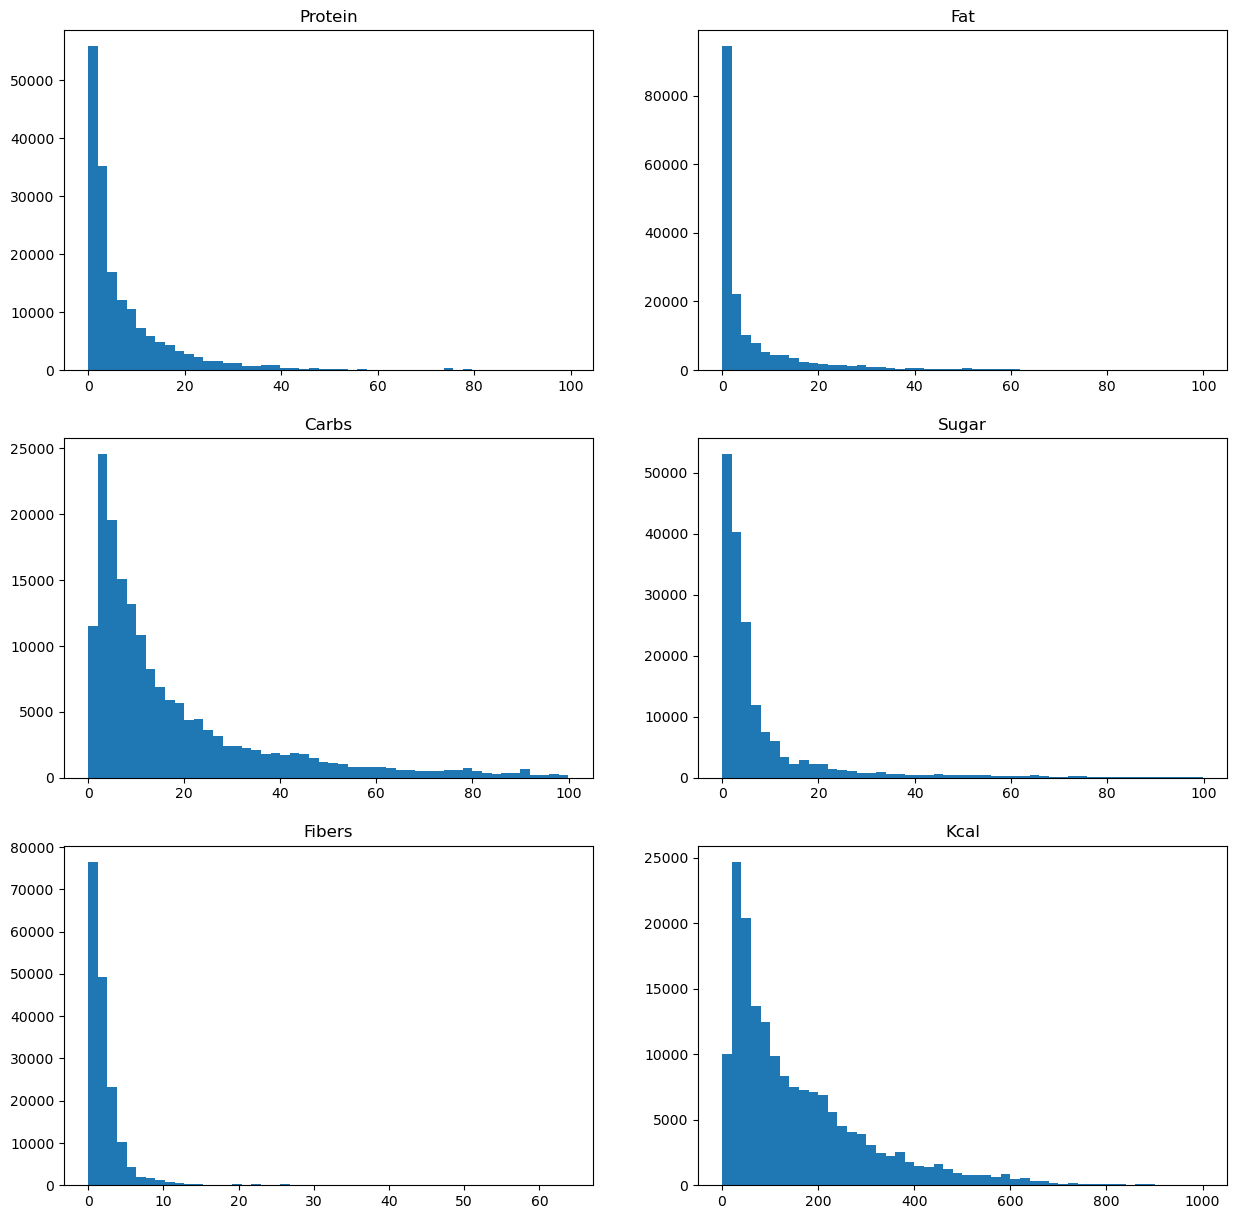

In [94]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist(recipe_nutrients_df['Protein'], bins=50)
axs[0, 0].set_title('Protein')
axs[0, 1].hist(recipe_nutrients_df['Fat'], bins=50)
axs[0, 1].set_title('Fat')
axs[1, 0].hist(recipe_nutrients_df['Carbs'], bins=50)
axs[1, 0].set_title('Carbs')
axs[1, 1].hist(recipe_nutrients_df['Sugar'], bins=50)
axs[1, 1].set_title('Sugar')
axs[2, 0].hist(recipe_nutrients_df['Fibers'], bins=50)
axs[2, 0].set_title('Fibers')
axs[2, 1].hist(recipe_nutrients_df['Kcal'], bins=50)
axs[2, 1].set_title('Kcal')
#plt.savefig('nutrients_histograms.png')
plt.show()


As we can see, there are some illogical results with some recipes displaying more than 100 grams of a given nutrient. I will exclude those recipes 

In [76]:
recipe_nutrients_df = recipe_nutrients_df[(recipe_nutrients_df['Carbs'] < 100) 
                         & (recipe_nutrients_df['Kcal'] < 1000)
                         & (recipe_nutrients_df['Kcal'] > 0)
                         & (recipe_nutrients_df['Fat'] < 100)
                         & (recipe_nutrients_df['Protein'] < 100)
                         & (recipe_nutrients_df['Sugar'] < 100)]
recipe_nutrients_df = recipe_nutrients_df.dropna()
recipe_nutrients_df.shape

(186254, 6)

In [79]:
def classify_recipe(row):
    if row['Kcal'] < 100:
        return 'Low Calorie'
    elif row['Kcal'] <= 300:
        return 'Moderate Calorie'
    else:
        return 'High Calorie'

def classify_by_macronutrients(row):
    if row['Protein'] > 10:
        return 'High Protein'
    elif row['Fat'] > 15:
        return 'High Fat'
    elif row['Carbs'] > 20:
        return 'High Carbs'
    else:
        return 'Balanced'

def classify_diet_suitability(row):
    if row['Carbs'] < 10 and row['Fat'] < 5:
        return 'Low Carb, Low Fat'
    elif row['Fibers'] > 3:
        return 'High Fiber'
    elif row['Carbs'] < 10:
        return 'Low Carb'
    elif row['Fat'] < 5:
        return 'Low Fat'
    else:
        return 'General'

def caloric_density(row):
    if (row['Protein'] + row['Carbs'] + row['Fat'] >0): 
        return row['Kcal']/(row['Protein'] + row['Carbs'] + row['Fat'])
    return None

def protein_Kcal_ratio(row):
    if row['Kcal'] == 0: 
        return None
    return row['Protein']/row['Kcal']

recipe_nutrients_df['Caloric Density'] = recipe_nutrients_df.apply(caloric_density, axis=1)
recipe_nutrients_df['Protein_Kcal Ratio'] = recipe_nutrients_df.apply(protein_Kcal_ratio, axis=1)
recipe_nutrients_df['Kcal Classification'] = recipe_nutrients_df.apply(classify_recipe, axis=1)
recipe_nutrients_df['Macronutrients Classification'] = recipe_nutrients_df.apply(classify_by_macronutrients, axis=1)
recipe_nutrients_df['Diet Suitability'] = recipe_nutrients_df.apply(classify_diet_suitability, axis=1)
recipe_nutrients_df.dropna(inplace=True)
#I assume that a recipe with a caloric density of more than 10 is not a valid entry in the dataset
recipe_nutrients_df = recipe_nutrients_df[recipe_nutrients_df['Caloric Density']<10]
print(recipe_nutrients_df.shape)
recipe_nutrients_df.head()

(172013, 11)


,Kcal,Fat,Carbs,Fibers,Protein,Sugar,Caloric Density,Protein_Kcal Ratio,Kcal Classification,Macronutrients Classification,Diet Suitability
German Sweet Potato Salad,105.552780,3.314384,12.888457,4.159106,6.301326,3.581144,4.690366,0.059698,Moderate Calorie,Balanced,High Fiber
Black Bean Chili,39.247104,2.054048,3.876520,0.772913,1.343920,1.540708,5.395170,0.034243,Low Calorie,Balanced,"Low Carb, Low Fat"
Madeira Duck With Mixed Wild Mushrooms,148.269650,1.378887,5.632484,5.561102,18.291302,5.445622,5.859841,0.123365,Moderate Calorie,High Protein,"Low Carb, Low Fat"
Grand Salmon Spread,82.906849,3.626564,5.778238,1.333046,7.470238,2.526489,4.912987,0.090104,Low Calorie,Balanced,"Low Carb, Low Fat"
Bean And Pasta Salad Recipe,471.586120,44.435216,13.147701,3.993024,6.069408,6.712235,7.408781,0.012870,High Calorie,High Fat,High Fiber


In [80]:
def is_nutritious(row):
    return(
        row['Macronutrients Classification'] =='Balanced' and
        row['Sugar'] < 5 
    )
    
recipe_nutrients_df['Nutritious'] = recipe_nutrients_df.apply(is_nutritious, axis=1)

recipe_nutrients_df.reset_index(inplace=True)
recipe_nutrients_df.rename(columns={'index':'title'}, inplace=True)
recipe_nutrients_df.head()


,title,Kcal,Fat,Carbs,Fibers,Protein,Sugar,Caloric Density,Protein_Kcal Ratio,Kcal Classification,Macronutrients Classification,Diet Suitability,Nutritious
0,German Sweet Potato Salad,105.552780,3.314384,12.888457,4.159106,6.301326,3.581144,4.690366,0.059698,Moderate Calorie,Balanced,High Fiber,True
1,Black Bean Chili,39.247104,2.054048,3.876520,0.772913,1.343920,1.540708,5.395170,0.034243,Low Calorie,Balanced,"Low Carb, Low Fat",True
2,Madeira Duck With Mixed Wild Mushrooms,148.269650,1.378887,5.632484,5.561102,18.291302,5.445622,5.859841,0.123365,Moderate Calorie,High Protein,"Low Carb, Low Fat",False
3,Grand Salmon Spread,82.906849,3.626564,5.778238,1.333046,7.470238,2.526489,4.912987,0.090104,Low Calorie,Balanced,"Low Carb, Low Fat",True
4,Bean And Pasta Salad Recipe,471.586120,44.435216,13.147701,3.993024,6.069408,6.712235,7.408781,0.012870,High Calorie,High Fat,High Fiber,False


In [81]:
recipe_nutrients_df.Nutritious.value_counts()

Nutritious
False    103678
True      68335
Name: count, dtype: int64

Finally I want to buiild a balanced dataset that I will use for fine tunning a BERT model for recipe classification. 

In [82]:

nutritious_recipes = recipe_nutrients_df[recipe_nutrients_df['Nutritious'] == True]
non_nutritious_recipes = recipe_nutrients_df[recipe_nutrients_df['Nutritious'] == False]

sampled_nutritious = nutritious_recipes.sample(65000, random_state=91)
sampled_non_nutritious = non_nutritious_recipes.sample(65000, random_state=91)

balanced_df = pd.concat([sampled_nutritious, sampled_non_nutritious])
final_sample_df = balanced_df[['title', 'Nutritious']].merge(sample[['title', 'text']], on='title', how='left')


#Export the final dataset used in the fine-tuning of the model
#final_sample_df.to_csv('fine_tune_data.csv', index=False)

## Fine-tuning recipe classification model 

Next I fine tune a recipe classification model using as a base model the pretrained RecipeBERT model. The model will classify a recipe as being Nutritious of Non-nutritious based on the text of the ingredients+instructions. 

To train the model I use a T4 GPU colab session to speed up the training process. I attach the used code to this notebook (commented) and I will use the saved model __Recipe_classifier__

In [83]:
###THIS CODE WAS USED TO FINE-TUNE THE MODEL IN GOOGLE COLAB USING A T4 GPU INSTANCE
###THE CODE IS COMMENTED OUT BECAUSE IT TAKES A LONG TIME TO RUN 
'''
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer

df["Nutritious"] = df["Nutritious"].apply(lambda x: 1 if x is True else 0)

# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["Nutritious"], test_size=0.2, random_state=91
)

# Convert to list format
train_texts, test_texts = train_texts.tolist(), test_texts.tolist()
train_labels, test_labels = train_labels.tolist(), test_labels.tolist()

# Load RecipeBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("alexdseo/RecipeBERT")

# Tokenize the text
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

#define a dataset class to use the encodings and labels in the model
class RecipeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype = torch.float32)
        return item

train_dataset = RecipeDataset(train_encodings, train_labels)
test_dataset = RecipeDataset(test_encodings, test_labels)


# Define a classification model using the RecipeBERT as the base model
model = AutoModelForSequenceClassification.from_pretrained(
    "alexdseo/RecipeBERT", num_labels=1
)

# Define output directory and logging directory for outputing the model results and logs
output_dir = "/content/drive/MyDrive/recipe-classification-bert/results"
logging_dir = "/content/drive/MyDrive/recipe-classification-bert/logs"

# Define training arguments
training_args = TrainingArguments(
    gradient_accumulation_steps=2,
    output_dir=output_dir,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir=output_dir,
    logging_steps=10,
    save_strategy="epoch"
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,

)

#TRAIN AND SAVE THE MODEL 
trainer.train()
model_save_path = "/content/drive/MyDrive/recipe-classification-bert/model"

# Save the fine-tuned model
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

'''

'\nfrom transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer\n\ndf["Nutritious"] = df["Nutritious"].apply(lambda x: 1 if x is True else 0)\n\n# Split into train and test sets\ntrain_texts, test_texts, train_labels, test_labels = train_test_split(\n    df["text"], df["Nutritious"], test_size=0.2, random_state=91\n)\n\n# Convert to list format\ntrain_texts, test_texts = train_texts.tolist(), test_texts.tolist()\ntrain_labels, test_labels = train_labels.tolist(), test_labels.tolist()\n\n# Load RecipeBERT tokenizer\ntokenizer = AutoTokenizer.from_pretrained("alexdseo/RecipeBERT")\n\n# Tokenize the text\ntrain_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)\ntest_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)\n\n#define a dataset class to use the encodings and labels in the model\nclass RecipeDataset(torch.utils.data.Dataset):\n    def __init__(self, encodings, labels):\n        

In [84]:
#load the saved fine-tuned model for classification
model_name = "Recipe_classifier"  
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def predict_nutritious(text):
    model_inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    model_outputs = model(**model_inputs)
    logits = model_outputs.logits
    score = logits[0][0].item()
    return score

In [85]:
final_sample_df = pd.read_csv('fine_tune_data.csv')

final_sample_df["Nutritious"] = final_sample_df["Nutritious"].apply(lambda x: 1 if x is True else 0)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    final_sample_df["text"], final_sample_df["Nutritious"], test_size=0.2, random_state=91
)

# Convert to list format
#train_texts, test_texts = train_texts.tolist(), test_texts.tolist()
#train_labels, test_labels = train_labels.tolist(), test_labels.tolist()

test_texts = pd.DataFrame(test_texts).reset_index()
test_labels = pd.DataFrame(test_labels).reset_index()
test_set = pd.merge(test_texts, test_labels, on='index')

# Due to resource constraints, I will sample 15000 recipes from the test set (appx 50% of the observations)
test_sample = test_set.sample(15000, random_state=91).reset_index(drop=True)
test_sample

,index,text,Nutritious
0,6069,"ingredients: [""3/4 c. Finely grnd blue cornmea...",1
1,28340,"ingredients: [""1 lb Ground beef"", ""1 packages ...",1
2,149808,"ingredients: [""1 1/2 lb ground beef"", ""1/2 med...",0
3,74567,"ingredients: [""1 tablespoon olive oil"", ""1 lb ...",1
4,115458,"ingredients: [""6 oz Emmentaler cheese, grated ...",0
...,...,...,...
14995,140082,"ingredients: [""2 -3 ripe bananas"", ""14 cup rai...",0
14996,40032,"ingredients: [""2 cup Sifted flour"", ""2 1/2 tsp...",1
14997,145825,"ingredients: [""2 cups Land O Lakes Half & Half...",0
14998,128965,"ingredients: [""1 12 teaspoons unflavored gelat...",0


In [86]:
# RUNNING THE CELL TAKES APPROXIMATELY 35 MINUTES
#test_sample['score']= test_sample['text'].apply(predict_nutritious)
#test_sample.to_csv('classification_results.csv', index=False)

# Load the results of the classification
test_sample_with_prediction = pd.read_csv('classification_results.csv')
test_sample_with_prediction.head(20)

,index,text,Nutritious,score,Predicted Nutritious
0,6069,"ingredients: [""3/4 c. Finely grnd blue cornmea...",1,0.875646,1
1,28340,"ingredients: [""1 lb Ground beef"", ""1 packages ...",1,0.660861,1
2,149808,"ingredients: [""1 1/2 lb ground beef"", ""1/2 med...",0,0.195957,0
3,74567,"ingredients: [""1 tablespoon olive oil"", ""1 lb ...",1,0.908706,1
4,115458,"ingredients: [""6 oz Emmentaler cheese, grated ...",0,0.512675,1
5,46719,"ingredients: [""1 12 cups dried garbanzo beans,...",1,0.975125,1
6,70431,"ingredients: [""6 oil-packed anchovy fillets"", ...",1,0.787701,1
7,30227,"ingredients: [""125 g sugar"", ""150 ml milk, hot...",1,0.906153,1
8,16048,"ingredients: [""8 ounces ground beef, cooked"", ...",1,0.824663,1
9,11676,"ingredients: [""1 medium onion, chopped"", ""2 cl...",1,0.907096,1


Looking at the first 20 entries in the results we have a feeling of the rather good performace of the model. Nevertheless, I look at the overall performance on the test dataset. 

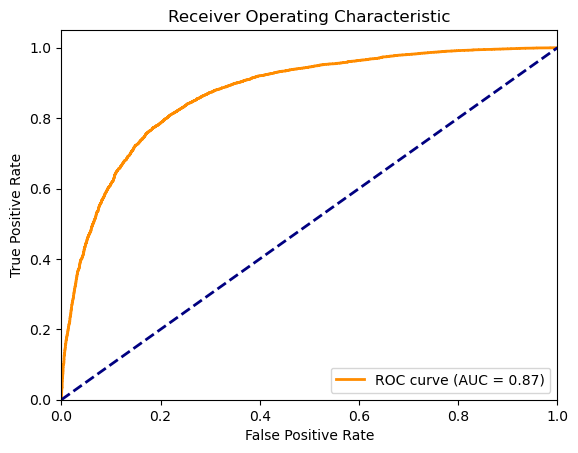

In [ ]:
#calculate the accuracy of the model
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_sample_with_prediction['Nutritious'], test_sample_with_prediction['score'])

roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('ROC_curve_classification.png')

plt.show()


In [89]:
# Find the index of the threshold with the highest Youden's Index
idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[idx]

print(f"Optimal Threshold: {optimal_threshold}")
test_sample['Predicted Nutritious'] = (test_sample_with_prediction['score'] > optimal_threshold).astype(int)

Optimal Threshold: 0.4941653609275818


This optimal threshold is expected given the balanced nature of the data set. 


In [90]:
print(classification_report(test_sample_with_prediction['Nutritious'], test_sample_with_prediction['Predicted Nutritious']))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      7425
           1       0.79      0.81      0.80      7575

    accuracy                           0.80     15000
   macro avg       0.80      0.79      0.79     15000
weighted avg       0.80      0.80      0.79     15000



## Conclusions 

The model has an overall 80% accuracy, which is reasonably good, considering that I only worked with a sample of 250k recipes (which after processing was reduced to appx 150K) and reduced computational power. Most likely extending the analysis and training to the entire dataset, would lead to better classification results. 

One possible limitation worth mentioning is in regards to the labeling of the dataset. The labeling I considered in this project is rather simple, only based on macronutrients information approximations. Other more complex labeling could be considered which might further inprove the accurracy of the model. Nevertheless, the core objective of this research was to showcase the possible use of nlp in understanding nutritional information and assist us in better nutrition decissions. 